In [1]:
import os 
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflow.keras.backend as K 
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, UpSampling2D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

2025-08-19 22:34:25.490421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755642865.731931      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755642865.800253      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Reading Data

In [2]:
train_image_dir = "/kaggle/input/road-lane-segmentation-train-test-split/train/images"
train_mask_dir = "/kaggle/input/road-lane-segmentation-train-test-split/train/masks"

train_image_files = sorted(os.listdir(train_image_dir))
train_mask_files = sorted(os.listdir(train_mask_dir))

val_image_dir = "/kaggle/input/road-lane-segmentation-train-test-split/valid/images"
val_mask_dir = "/kaggle/input/road-lane-segmentation-train-test-split/valid/masks"

val_image_files = sorted(os.listdir(val_image_dir))
val_mask_files = sorted(os.listdir(val_mask_dir))

print(f"Number of training images:{len(train_image_files)}, Number of training masks: {len(train_mask_files)}" )
print(f"Number of val images:{len(val_image_files)}, Number of val masks: {len(val_mask_files)}" )

Number of training images:299, Number of training masks: 299
Number of val images:74, Number of val masks: 74


In [3]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

train_images = []
train_masks = []
for img_name, mask_name in zip(train_image_files, train_mask_files):
    img = cv2.imread(os.path.join(train_image_dir, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255.0
    train_images.append(img)

    mask = cv2.imread(os.path.join(train_mask_dir, mask_name))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    train_masks.append(mask)


val_images = []
val_masks = []
for img_name, mask_name in zip(val_image_files, val_mask_files):
    img = cv2.imread(os.path.join(val_image_dir, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255.0
    val_images.append(img)

    mask = cv2.imread(os.path.join(val_mask_dir, mask_name))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    val_masks.append(mask)    


train_images = np.array(train_images)
train_masks = np.array(train_masks)
val_images = np.array(val_images)
val_masks = np.array(val_masks)

print(train_images.shape, train_masks.shape)
print(val_images.shape, val_masks.shape)

(299, 256, 256, 3) (299, 256, 256, 3)
(74, 256, 256, 3) (74, 256, 256, 3)


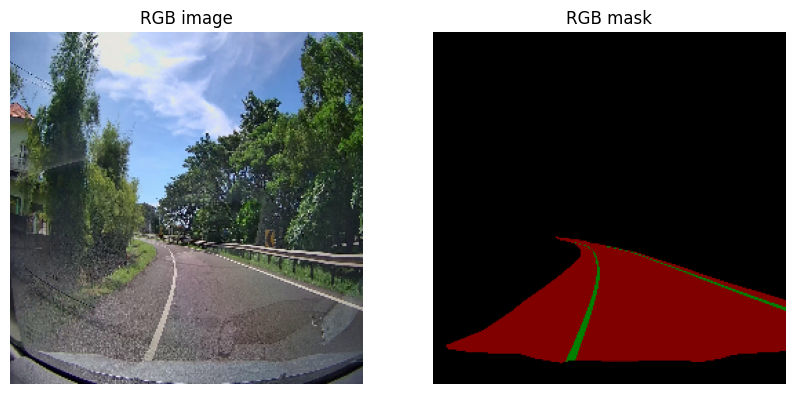

In [4]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(train_images[100])
plt.title('RGB image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(train_masks[100])
plt.title('RGB mask')
plt.axis('off')
plt.show()

## Convert to class idx

In [5]:
COLOR_MAP = {
    (0, 0, 0): 0,        # Background
    (128,0,0): 1,        # Road
    (0,128,0):2,         #Lane mark solid
    (128,128,0):3        #Lane mark dashed
}

NUM_CLASSES = len(COLOR_MAP)

def rgb_to_class(mask_rgb, color_map):
    h, w, _ = mask_rgb.shape
    class_mask = np.zeros((h, w), dtype=np.int32)
    for color, class_id in color_map.items():
        matches = np.all(mask_rgb == color, axis=-1)
        class_mask[matches] = class_id
    return class_mask

train_class_mask = []
for mask in train_masks: 
    mask = rgb_to_class(mask, COLOR_MAP)
    train_class_mask.append(mask)
    
train_class_masks = np.array(train_class_mask)

val_class_mask = []
for mask in val_masks: 
    mask = rgb_to_class(mask, COLOR_MAP)
    val_class_mask.append(mask)
    
val_class_masks = np.array(val_class_mask)

In [6]:
print(np.unique(train_class_masks))

[0 1 2 3]


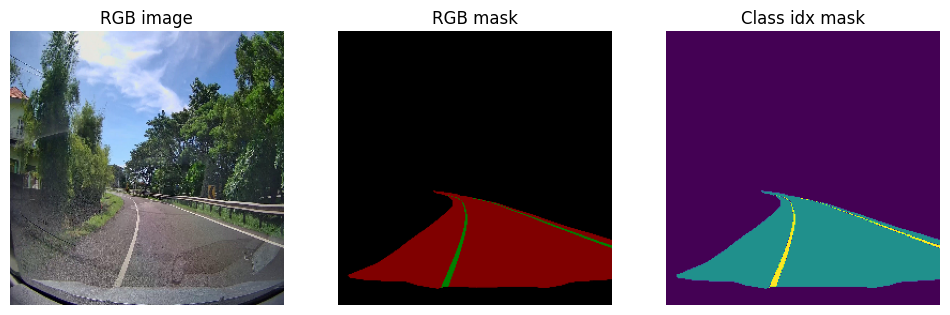

In [7]:
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.imshow(train_images[100])
plt.title('RGB image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(train_masks[100])
plt.title('RGB mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(train_class_masks[100])
plt.title('Class idx mask')
plt.axis('off')
plt.show()

## Data Augmentation

In [8]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [9]:
import albumentations as A

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomCrop(width=256, height=256, p=0.8),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0, p=0.4),
])

In [10]:
aug_images1 = []
aug_masks1 = []

for img, mask in zip(train_images, train_class_masks):
    augmented = train_transform(image=img, mask=mask)
    aug_images1.append(augmented['image'])
    aug_masks1.append(augmented['mask'])

aug_images1 = np.array(aug_images1)
aug_masks1 = np.array(aug_masks1)

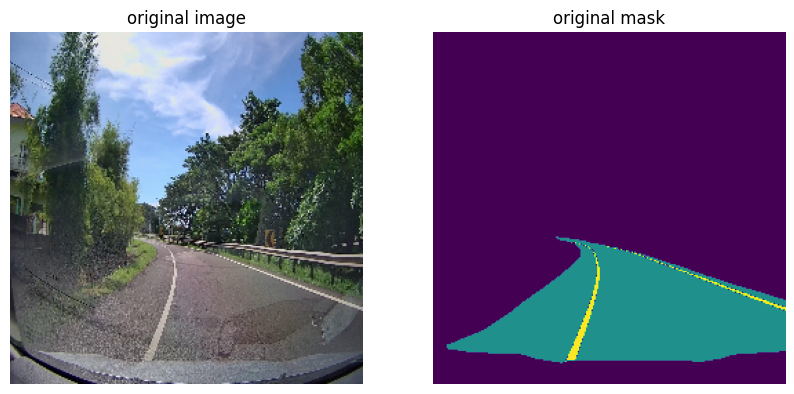

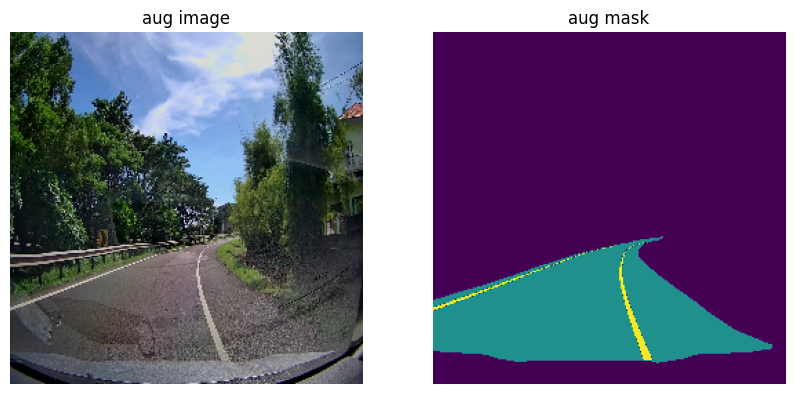

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(train_images[100])
plt.title('original image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(train_class_masks[100])
plt.title('original mask')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(aug_images1[100])
plt.title('aug image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(aug_masks1[100])
plt.title('aug mask')
plt.axis('off')
plt.show()

## More augmentation to enhance data

In [12]:
train_transform2 =  A.Compose([
        A.RandomBrightnessContrast(p=0.5),
        A.RandomCrop(height=256, width=256, p=1),
        A.VerticalFlip(p=1),
        A.Rotate(limit=20, p=1),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0, p=0.4),
    ])

aug_images2 = []
aug_masks2 = []

for img, mask in zip(train_images, train_class_masks):
    augmented = train_transform2(image=img, mask=mask)
    aug_images2.append(augmented['image'])
    aug_masks2.append(augmented['mask'])

aug_images2 = np.array(aug_images2)
aug_masks2 = np.array(aug_masks2)


aug_images = np.concatenate([aug_images1, aug_images2], axis=0)
aug_masks = np.concatenate([aug_masks1, aug_masks2], axis=0) 
print(aug_images.shape, aug_masks.shape)

(598, 256, 256, 3) (598, 256, 256)


### one-hot encode masks 

In [13]:
train_masks_onehot2 = np.array([to_categorical(mask, NUM_CLASSES) for mask in aug_masks]) # one_hot augmented masks
train_masks_onehot = np.array([to_categorical(mask, NUM_CLASSES) for mask in train_class_masks]) # one_hot normal masks
val_masks_onehot = np.array([to_categorical(mask, NUM_CLASSES) for mask in val_class_masks]) # one_hot val_masks

In [14]:
X_train = np.concatenate([train_images, aug_images], axis=0)
y_train = np.concatenate([train_masks_onehot, train_masks_onehot2], axis=0)
X_val = val_images
y_val = val_masks_onehot 
print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_val.shape, y_val.shape)

Train: (897, 256, 256, 3) (897, 256, 256, 4)
Test:  (74, 256, 256, 3) (74, 256, 256, 4)


## Define Model

In [15]:
def unet_model(input_size=(256,256,3)):
  inputimg = Input(input_size)

  # encoder
    
  c1 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputimg)
  c1 = BatchNormalization()(c1) 
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c1)
  #p1 = MaxPooling2D(2,2)(c1)
  p1 = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(c1)
    
  c2 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p1)
  c2 = BatchNormalization()(c2)
  c2 = Dropout(0.1)(c2)  
  c2 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c2)
  #p2 = MaxPooling2D(2,2)(c2)
  p2 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(c2)
    
  c3 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p2)
  c3 = BatchNormalization()(c3)
  c3 = Dropout(0.1)(c3)
  c3 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c3)
  #p3 = MaxPooling2D(2,2)(c3)
  p3 = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(c3)
    
  c4 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p3)
  c4 = BatchNormalization()(c4)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c4)
  #p4 = MaxPooling2D(2,2)(c4)
  p4 = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(c4)
    
  c5 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p4)
  c5 = BatchNormalization()(c5)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c5)
  #p5 = MaxPooling2D(2,2)(c5)
  p5 = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(c5)
    
  # bottle-neck
  b = Conv2D(1024, (3,3), activation='relu', dilation_rate=2, padding='same', kernel_initializer = 'he_normal')(p5)
  b = BatchNormalization()(b)
  b = Dropout(0.3)(b)
  b = Conv2D(1024, (3,3), activation='relu',dilation_rate=2, padding='same', kernel_initializer = 'he_normal')(b)

 # decoder 
  u1 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same', kernel_initializer = 'he_normal')(b)
  u1 = concatenate([u1,c5])
  c5 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u1)
  c5 = BatchNormalization()(c5)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(512, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c5)

  u2 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same', kernel_initializer = 'he_normal')(c5)
  u2 = concatenate([u2,c4])
  c6 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u2)
  c6 = BatchNormalization()(c6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c6)

  u3 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', kernel_initializer = 'he_normal')(c6)
  u3 = concatenate([u3,c3])
  c7 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u3)
  c7 = BatchNormalization()(c7)
  c7 = Dropout(0.1)(c7)
  c7 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c7)

  u4 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', kernel_initializer = 'he_normal')(c7)
  u4 = concatenate([u4,c2])
  c8 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u4)
  c8 = BatchNormalization()(c8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c8)

  u5 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', kernel_initializer = 'he_normal')(c8)
  u5 = concatenate([u5,c1])
  c9 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u5)
  c9 = BatchNormalization()(c9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c9)
    
  out = Conv2D(4, (1,1), activation='softmax' )(c9)

  model = Model(inputs = [inputimg], outputs = [out])

  return model

In [16]:
model = unet_model()
model.summary()

I0000 00:00:1755642925.164234      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     18,496 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    295,168 │ conv2d_8[0][0]  

 Total params: 34,250,276 (130.65 MB)

 Trainable params: 34,244,260 (130.63 MB)

 Non-trainable params: 6,016 (23.50 KB)

In [17]:
from tensorflow.keras import backend as K

def dice_coef_per_class(class_idx, smooth=1e-6):
    def dice(y_true, y_pred):
        y_true_f = K.flatten(y_true[..., class_idx])
        y_pred_f = K.flatten(y_pred[..., class_idx])
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def iou_per_class(class_idx, smooth=1):
    def iou(y_true, y_pred):
        y_true_f = K.flatten(y_true[..., class_idx])
        y_pred_f = K.flatten(y_pred[..., class_idx])
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
        return (intersection + smooth) / (union + smooth)
    return iou

In [18]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanMetricWrapper(iou_per_class(0), name='iou_class_0'),
        tf.keras.metrics.MeanMetricWrapper(iou_per_class(1), name='iou_class_1'),
        tf.keras.metrics.MeanMetricWrapper(iou_per_class(2), name='iou_class_2'),
        tf.keras.metrics.MeanMetricWrapper(iou_per_class(3), name='iou_class_3'), 
        tf.keras.metrics.MeanMetricWrapper(dice_coef_per_class(0), name='dice_class_0'),
        tf.keras.metrics.MeanMetricWrapper(dice_coef_per_class(1), name='dice_class_1'),
        tf.keras.metrics.MeanMetricWrapper(dice_coef_per_class(2), name='dice_class_2'),
        tf.keras.metrics.MeanMetricWrapper(dice_coef_per_class(3), name='dice_class_3'),
        
    ]
)
save_model = ModelCheckpoint('best_model.h5',
                             monitor='val_loss', save_best_only=True)

## Training

In [20]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs = 60,
                    callbacks=[save_model]
                   )

Epoch 1/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.3766 - dice_class_0: 0.4661 - dice_class_1: 0.2517 - dice_class_2: 0.0092 - dice_class_3: 0.0014 - iou_class_0: 0.3055 - iou_class_1: 0.1443 - iou_class_2: 0.0046 - iou_class_3: 7.2006e-04 - loss: 1.3876

E0000 00:00:1755643176.501558     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755643176.737077     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


29/29 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3799 - dice_class_0: 0.4680 - dice_class_1: 0.2526 - dice_class_2: 0.0092 - dice_class_3: 0.0014 - iou_class_0: 0.3073 - iou_class_1: 0.1449 - iou_class_2: 0.0046 - iou_class_3: 7.2233e-04 - loss: 1.3813 - val_accuracy: 0.6838 - val_dice_class_0: 0.5815 - val_dice_class_1: 0.1997 - val_dice_class_2: 0.0083 - val_dice_class_3: 0.0015 - val_iou_class_0: 0.4100 - val_iou_class_1: 0.1110 - val_iou_class_2: 0.0041 - val_iou_class_3: 7.6201e-04 - val_loss: 1.0541
Epoch 2/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 428ms/step - accuracy: 0.7865 - dice_class_0: 0.7155 - dice_class_1: 0.3684 - dice_class_2: 0.0105 - dice_class_3: 0.0024 - iou_class_0: 0.5594 - iou_class_1: 0.2268 - iou_class_2: 0.0053 - iou_class_3: 0.0012 - loss: 0.7002 - val_accuracy: 0.8237 - val_dice_class_0: 0.7281 - val_dice_class_1: 0.2100 - val_dice_class_2: 0.0079 - val_dice_class_3: 0.0015 - val_iou_class_0: 0.5725 - val_iou_class_1: 0.1177 - val_iou_class_2: 0.0040 - val_iou

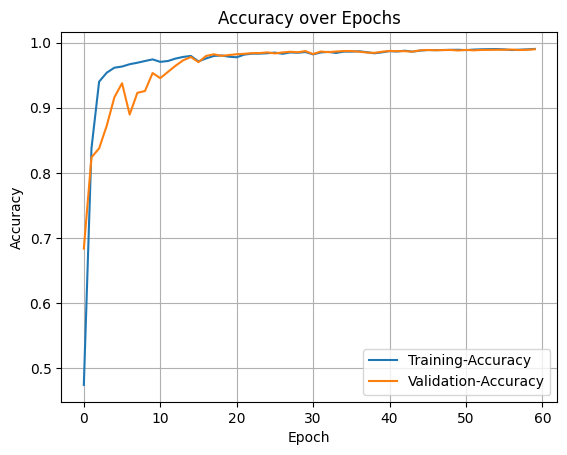

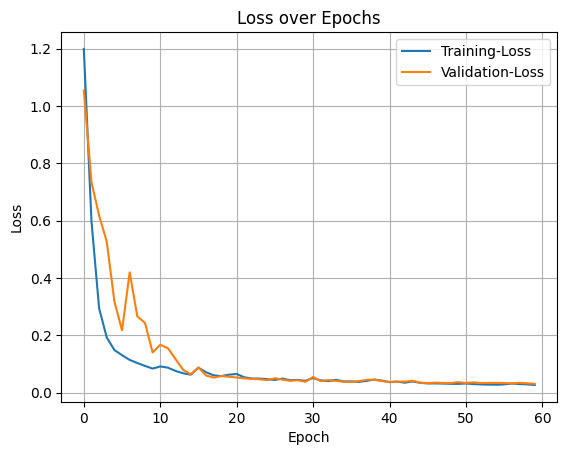

In [21]:
plt.plot(history.history['accuracy'], label = 'Training-Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation-Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['loss'], label = 'Training-Loss')
plt.plot(history.history['val_loss'], label = 'Validation-Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

### Evaluating & Plotting prediction

In [23]:
loss, acc, c0, c1, c2, c3, i0, i1, i2, i3 = model.evaluate(X_val, y_val)
print(f"validation Accuracy : {acc}")
print(f"Validation Loss : {loss}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9896 - dice_class_0: 0.9926 - dice_class_1: 0.9622 - dice_class_2: 0.6068 - dice_class_3: 0.3122 - iou_class_0: 0.9854 - iou_class_1: 0.9272 - iou_class_2: 0.4398 - iou_class_3: 0.1914 - loss: 0.0316 
validation Accuracy : 0.9896619915962219
Validation Loss : 0.030915649607777596


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


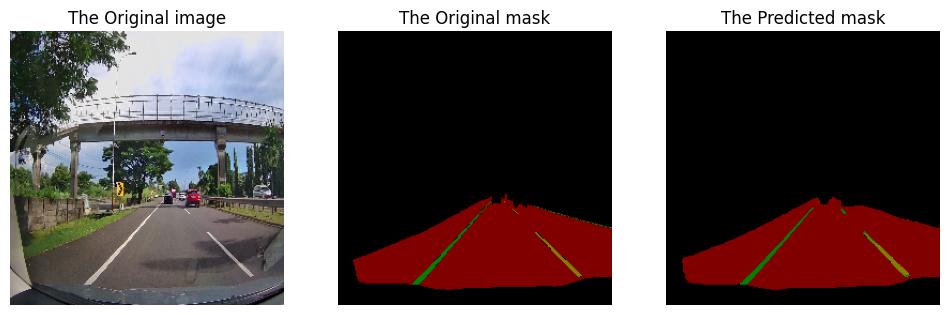

In [22]:
image = X_val[50]
true_mask = y_val[50] 
pred = model.predict(np.expand_dims(image, axis=0))
pred_mask = np.argmax(pred[0], axis=-1).astype(np.uint8)

if true_mask.ndim == 3 and true_mask.shape[-1] > 1:
    true_mask = np.argmax(true_mask, axis=-1)

def class_to_rgb(mask, class_colors):
    rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for idx, color in enumerate(class_colors):
        rgb[mask == idx] = color
    return rgb

true_rgb = class_to_rgb(true_mask, COLOR_MAP)
pred_rgb = class_to_rgb(pred_mask, COLOR_MAP)

plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('The Original image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_rgb)
plt.title('The Original mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_rgb)
plt.title('The Predicted mask')
plt.axis('off')

plt.show()
